# Handwritten Digits

### Importo le librerie

In [8]:
import warnings
warnings.filterwarnings("ignore")

import os  
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tinymlgen import port
from matplotlib import pyplot as plt

tf.random.set_seed(1337)
np.random.seed(1337)

### Carico il Dataset ed eseguo lo split

In [14]:
# carico il dataset
x_values, y_values = load_digits(return_X_y=True)

print("Total samples: " + str(x_values.shape[0]))

x_values /= x_values.max()

# reshape a (8 x 8 x 1)
x_values = x_values.reshape((len(x_values), 8, 8, 1))

# divido in train, validation e test
TRAIN_SPLIT = int(0.6 * len(x_values))
TEST_SPLIT = int(0.2 * len(x_values) + TRAIN_SPLIT)
x_train, x_test, x_validate = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

x_test = (x_test / x_test.max()).reshape((len(x_test), 8, 8, 1))

print("Train samples: " + str(x_train.shape))
print("Validation samples: " + str(x_validate.shape))
print("Test samples: " + str(x_test.shape))


Total samples: 1797
Train samples: (1078, 8, 8, 1)
Validation samples: (360, 8, 8, 1)
Test samples: (359, 8, 8, 1)


### Visualizzzo il Dataset

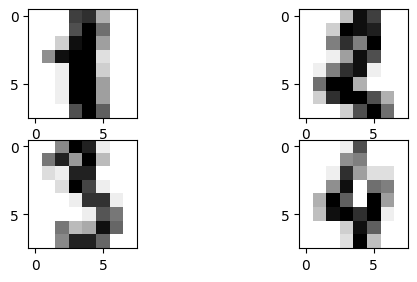

In [3]:
# 4 immagini dal dataset
for i in range(1, 5):
    plt.subplot(3, 2, i)
    plt.imshow(x_train[i], cmap=plt.cm.gray_r, interpolation="nearest")

### Creazione del modello

In [4]:
# creo una CNN
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(8, (3, 3), activation="relu", input_shape=(8, 8, 1)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(16, (3, 3), activation="relu"))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10))

model.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])
model.fit(x_train, y_train, epochs=50, batch_size=16, validation_data=(x_validate, y_validate))


Epoch 1/50
68/68 [==============================] - 2s 9ms/step - loss: 2.2511 - accuracy: 0.2375 - val_loss: 2.1834 - val_accuracy: 0.3500
Epoch 2/50
68/68 [==============================] - 0s 5ms/step - loss: 2.0643 - accuracy: 0.3859 - val_loss: 1.9330 - val_accuracy: 0.3944
Epoch 3/50
68/68 [==============================] - 0s 4ms/step - loss: 1.7126 - accuracy: 0.5204 - val_loss: 1.5331 - val_accuracy: 0.6000
Epoch 4/50
68/68 [==============================] - 0s 5ms/step - loss: 1.2577 - accuracy: 0.7291 - val_loss: 1.1419 - val_accuracy: 0.7083
Epoch 5/50
68/68 [==============================] - 0s 5ms/step - loss: 0.8991 - accuracy: 0.8126 - val_loss: 0.9222 - val_accuracy: 0.7528
Epoch 6/50
68/68 [==============================] - 0s 5ms/step - loss: 0.6662 - accuracy: 0.8553 - val_loss: 0.8185 - val_accuracy: 0.7389
Epoch 7/50
68/68 [==============================] - 0s 5ms/step - loss: 0.5283 - accuracy: 0.8822 - val_loss: 0.7713 - val_accuracy: 0.7611
Epoch 8/50
68/68 [==

### Accuratezza del modello

In [5]:
# testo il modello
y_pred = model.predict(x_test).argmax(axis=1)

print("Model accuracy:", accuracy_score(y_test, y_pred))


12/12 [==============================] - 0s 2ms/step
Model accuracy: 0.9415041782729805


### Seleziono un sample dal Dataset di test da salvare nel file header

In [6]:
cpp_dataset_variables = ""

# seleziono il primo sample del test set
first_sample_x = x_test[0]
first_sample_y = y_test[0]

cpp_dataset_variables = "float x_test[64] = "

x_values_str = str([ x[0] for line in first_sample_x for x in line ])
x_values_str = x_values_str.replace("[", "{ ")
x_values_str = x_values_str.replace("]", " };\n")

cpp_dataset_variables += x_values_str

cpp_dataset_variables += "const int y_test = " + str(first_sample_y) + ";"

print(cpp_dataset_variables)


float x_test[64] = { 0.0, 0.125, 0.0, 0.5, 0.5625, 0.0, 0.0, 0.0, 0.0, 0.8125, 0.3125, 0.875, 0.5, 0.4375, 0.0, 0.0, 0.0, 0.75, 0.3125, 0.125, 0.0, 0.5625, 0.0, 0.0, 0.0, 0.4375, 0.3125, 0.0, 0.0, 0.1875, 0.3125, 0.0, 0.0, 0.1875, 0.625, 0.0, 0.0, 0.125, 0.625, 0.0, 0.0, 0.0625, 0.8125, 0.0, 0.0, 0.0625, 0.75, 0.0, 0.0, 0.0, 0.3125, 0.8125, 0.3125, 0.5625, 0.8125, 0.0, 0.0, 0.0, 0.0, 0.5625, 1.0, 1.0, 0.4375, 0.0 };
const int y_test = 0;


### Salvo il modello nel file header

In [7]:
cpp_code = port(model, variable_name="HandwrittenDigitsModel", pretty_print=True, optimize=False)

cpp_code += "\n"
cpp_code = cpp_code + cpp_dataset_variables

# cpp files
with open("assets/cpp_files/HandwrittenDigits.h", "w+") as f:
    f.write(cpp_code)
    
# esp32
with open("../HandwrittenDigits/HD_ESP32/include/HandwrittenDigits.h", "w+") as f:
    f.write(cpp_code)

# esp8266
with open("../HandwrittenDigits/HD_ESP8266/include/HandwrittenDigits.h", "w+") as f:
    f.write(cpp_code)

# wemos
with open("../HandwrittenDigits/HD_WEMOS/include/HandwrittenDigits.h", "w+") as f:
    f.write(cpp_code)


INFO:tensorflow:Assets written to: /var/folders/k6/0tv_bzp937scnn3d7yzhy1vr0000gn/T/tmp7d752472/assets


INFO:tensorflow:Assets written to: /var/folders/k6/0tv_bzp937scnn3d7yzhy1vr0000gn/T/tmp7d752472/assets
